### Data cleaning
* Fields to drop: Unnamed: 0, url, region_url, description, region or state?
* Fields to keep but won't be used for prediction:  VIN will be used to get missing data and to dedupe, image_url - may be used for visualization, latitude, longitude
* Fields used for prediction:  region/state, year (or age), manufacturer, model, condition, cylinders, fuel, odometer, title_status, transmission, drive, size, type, paint_color
* Fields to predict:  price (regression), price range category
* The price field has some extreme outliers (3.5 billion) and dummy.  We will keep everything under 4 million and remove 1234567 and 111111 and 9999999.  - Kristi 
* The year field we will keep years with 0.05 percent or above. - Sam
* The posting_date should be converted to a datetime field - Kristi
* Lat/Long will only be visualization.  If state is available, we will impute lat/long with the state lat/long. - Rudranil
* Odometer values less than 1 million - Simerpreet
* Condition - group these: ('good', 'fair'), ('excellent','like new'), 'salvage', 'new' - One Hot Encoding - Kristi
* Convert cylinders to integer.  Drop rows with "other" cyclinders. - Sam
* Cars are listed in multiple regions  - Rudranil to work on dedupe 
* Cylinders, type, size, year, manufacturer, model, transmission, drive? fuel? na's will be acquired from Dept of Transportation (Exceptional!) - Rudranil
* In addition to Condition, we need to One Hot Encode drive, size, type, paint_color - Sam
* Type field remove 'other and 'bus' and re-grouping the remaining ones to:  'sedan', ('wagon','SUV') and call it 'crossover', ('pickup', 'truck'), 'coupe', 'van', 'mini-van', 'convertible', 'hatchback', 'offroad' - Simerpeet
* Manufacturer:  drop 'harley-davidson', 'morgan'- Kristi
* Title_status:  drop na's - Sam
* New column:  age of the car (posting_date - year), price category range (0-999, 1000 - 5000, 5000 - 9999, etc. etc.) - Simerpreet

# Lab 1

Group 4:  Simerpreet Reddy, Rudranil Mitra, Samuel VonPaays Soh, Kristi Herman

---
### Business Understanding

The source selected for this analysis is a Craigslist used car listings dataset from Kaggle:  https://www.kaggle.com/austinreese/craigslist-carstrucks-data<br>


#### Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?)
The purpose of this dataset is to collect all used cars and trucks for sale in the U.S. that are listed on Craigslist regional sites.  This dataset can be used to model and predict used car prices as well as the condition of a car.     


#### Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? 

We will know that we have mined useful knowledge if we are able to come up with a good prediction of used car prices and classifier for the condition of the car.

#### How would you measure the effectiveness of a good prediction algorithm? Be specific.
For the regression problem to predict car prices, RMSE will be used determine effectiveness of the prediction. For the classification problem, 10-fold cross validation with accuracy, precision, and recall to measure the effectiveness of the prediction model (l1, l2 regularization).


### Data Meaning Type

*Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.*



In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True)

In [86]:
#import data field descriptions
desc_df = pd.read_csv('data/fields.csv') 
print("The dataset contains 458,213 rows with the following 26 fields:")
pd.set_option('display.max_colwidth', -1)
desc_df

The dataset contains 458,213 rows with the following 26 fields:


Field  \
0   Unnamed: 0     
1   id             
2   url            
3   region         
4   region_url     
5   price          
6   year           
7   manufacturer   
8   model          
9   condition      
10  cylinders      
11  fuel           
12  odometer       
13  title_status   
14  transmission   
15  VIN            
16  drive          
17  size           
18  type           
19  paint_color    
20  image_url      
21  description    
22  state          
23  lat            
24  long           
25  posting_date   

                                                                                                                                                       Description  \
0   id for the entry in the dataset ranging from 0 - 458,212                                                                                                         
1   Unique Craigslist identifier for the listing                                                                                                                     
2   URL for the listing                                                                                                                                              
3   Craig's list region, usually a city like las vegas.  In some cases it willl be the whole state, e.g., wyoming.  There are 405 unique regions.                    
4   The URL for the regional site, e.g., https://newyork.craigslist.org/.  There are  413 unique region_urls.                                                        
5   The price of the used car in USD from 0 - 3.5 billion                                                                                                            
6   The year the car was made from 1900 - 2021                                                                                                                       
7   The manufacturer of the car, e.g., honda or jeep.  There are 44 unique manufacturers.                                                                            
8   The model of the car, e.g. f150, malibu, or focus.  There are 31,521 unique models.                                                                              
9   The condition of the car with these values: 'salvage',   'fair',  'good', 'excellent', 'like new',' new'                                                         
10  Number of cylinders ranging from 3 - 12 as well as an 'other' category.                                                                                          
11  Type of fuel with these values:  'gas', 'diesel', 'other', 'hybrid', 'electric'                                                                                  
12  Mileage recorded                                                                                                                                                 
13  Indicates what the title_status of the car is:  'clean', 'lien', 'missing', 'salvage', 'rebuilt', 'parts only'                                                   
14  Type of transmission:  'other', 'automatic', 'manual'                                                                                                            
15  Vehicle Identification Number                                                                                                                                    
16  Type of drive: ' rwd', 'fwd',  '4wd'                                                                                                                             
17  Size of the car:  full-size', 'mid-size', 'compact', 'sub-compact'                                                                                               
18  Type of vehicle with 14 values:  'other', 'sedan', 'SUV', 'pickup', 'coupe', 'van', 'truck', 'mini-van', 'wagon', 'convertible', 'hatchback', 'bus', 'offroad'   
19  Color of the car with 13 values:  'blue', 'red', 'silver', 'black', 'white', 'grey', 'orange', 'green', 'yellow', 'custom', 'brown', 'purple'     

In [98]:
#import data
orig_df = pd.read_csv('data/vehicles.csv') 

In [168]:
#copy original file to df
car_df = orig_df
#info
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 26 columns):
Unnamed: 0      458213 non-null int64
id              458213 non-null int64
url             458213 non-null object
region          458213 non-null object
region_url      458213 non-null object
price           458213 non-null int64
year            457163 non-null float64
manufacturer    439993 non-null object
model           453367 non-null object
condition       265273 non-null object
cylinders       287073 non-null object
fuel            454976 non-null object
odometer        402910 non-null float64
title_status    455636 non-null object
transmission    455771 non-null object
VIN             270664 non-null object
drive           324025 non-null object
size            136865 non-null object
type            345475 non-null object
paint_color     317370 non-null object
image_url       458185 non-null object
description     458143 non-null object
state           458213 non-null 

### Data Quality
Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods

### Simple Statistics
Visualize appropriate statistics (e.g., range, mode, mean, median, variance, counts) for a subset of attributes. Describe anything meaningful you found from this or if you found something potentially interesting. Note: You can also use data from other sources for comparison. Explain why the statistics run are meaningful. 

### Visualize Attributes
Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.

### Explore Joint Attributes
Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.

### Explore Attributes and Class
Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).

### New Features
Are there other features that could be added to the data or created from existing features? Which ones?

### Exceptional Work
You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results.

In [169]:
#view head
pd.set_option('display.max_columns', None)
car_df.head(300)

Unnamed: 0          id  \
0    0           7240372487   
1    1           7240309422   
2    2           7240224296   
3    3           7240103965   
4    4           7239983776   
5    5           7239776805   
6    6           7239425036   
7    7           7238667661   
8    8           7238127696   
9    9           7237779886   
10   10          7237759157   
11   11          7237595428   
12   12          7237366792   
13   13          7237318515   
14   14          7237009212   
15   15          7236904120   
16   16          7236744893   
17   17          7236413365   
18   18          7236210088   
19   19          7235942858   
20   20          7235940317   
21   21          7235872843   
22   22          7235646387   
23   23          7235307107   
24   24          7234696298   
25   25          7234690164   
26   26          7234656040   
27   27          7234049465   
28   28          7233929294   
29   29          7233494314   
30   30          7233204025   
31   31          7233203718   
32   32          7233202131   
33   33          7233201758   
34   34          7233201530   
35   35          7233201268   
36   36          7233201011   
37   37          7233200074   
38   38          7233191380   
39   39          7233190065   
40   40          7233189941   
41   41          7232940151   
42   42          7232651921   
43   43          7232374487   
44   44          7231869050   
45   45          7231766303   
46   46          7231287950   
47   47          7231143951   
48   48          7230930424   
49   49          7230171255   
50   50          7229898744   
51   51          7229854435   
52   52          7229852078   
53   53          7229851204   
54   54          7229851010   
55   55          7229601549   
56   56          7229266718   
57   57          7229266483   
58   58          7229265364   
59   59          7229265094   
60   60          7229264602   
61   61          7229031989   
62   62          7228922985   
63   63          7228537393   
64   64          7228389071   
65   65          7228156160   
66   66          7227857419   
67   67          7227394599   
68   68          7226976391   
69   69          7226955211   
70   70          7226689081   
71   71          7226688622   
72   72          7226687735   
73   73          7226687427   
74   74          7226342465   
75   75          7226013305   
76   76          7226012684   
77   77          7226011596   
78   78          7226011362   
79   79          7226011186   
80   80          7225770216   
81   81          7225254442   
82   82          7225122235   
83   83          7225028142   
84   84          7225027930   
85   85          7225027697   
86   86          7225027497   
87   87          7224721727   
88   88          7240596449   
89   89          7240588489   
90   90          7240573110   
91   91          7240569685   
92   92          7240567296   
93   93          7240566811   
94   94          7240566791   
95   95          7240566722   
96   96          7240548971   
97   97          7240543174   
98   98          7240485219   
99   99          7240483721   
100  100         7240482962   
101  101         7240468496   
102  102         7240467119   
103  103         7240462455   
104  104         7240460935   
105  105         7240441906   
106  106         7240442519   
107  107         7240441395   
108  108         7240431889   
109  109         7240421929   
110  110         7240419921   
111  111         7240420757   
112  112         7240410528   
113  113         7240410510   
114  114         7240410494   
115  115         7240410408   
116  116         7240406108   
117  117         7240406130   
118  118         7240401680   
119  119         7240399445   
120  120         7240385231   
121  121         7240356621   
122  122         7240340486   
123  123         7240308513   
124  124         7240237963   
125  125         7240226152   
126  126         7240224174   
127  127         7240216191   
128  1

In [171]:
#get shape of df
car_df.shape

(458213, 26)

In [170]:
#describe
car_df.describe()

Unnamed: 0            id         price           year      odometer  \
count  458213.000000  4.582130e+05  4.582130e+05  457163.000000  4.029100e+05   
mean   229106.000000  7.235233e+09  4.042093e+04  2010.746067    1.016698e+05   
std    132274.843786  4.594362e+06  8.194599e+06  8.868136       3.228623e+06   
min    0.000000       7.208550e+09  0.000000e+00  1900.000000    0.000000e+00   
25%    114553.000000  7.231953e+09  4.900000e+03  2008.000000    4.087700e+04   
50%    229106.000000  7.236409e+09  1.099500e+04  2013.000000    8.764100e+04   
75%    343659.000000  7.239321e+09  2.149500e+04  2016.000000    1.340000e+05   
max    458212.000000  7.241019e+09  3.615215e+09  2021.000000    2.043756e+09   

                 lat           long  
count  450765.000000  450765.000000  
mean   38.531925     -94.375824      
std    5.857378       18.076225      
min   -82.607549     -164.091797     
25%    34.600000     -110.890427     
50%    39.244500     -88.314889      
75%    42.484503     -81.015022      
max    82.049255      150.898969

In [172]:
a = car_df['year'].value_counts() / len(car_df) * 100
a.sort_values()


1919.0    0.000218
1920.0    0.000218
1918.0    0.000218
1915.0    0.000218
1910.0    0.000218
1913.0    0.000218
1921.0    0.000218
1922.0    0.000218
1945.0    0.000436
1943.0    0.000436
1914.0    0.000436
1911.0    0.000873
1912.0    0.001091
1925.0    0.001528
1924.0    0.001746
1942.0    0.002401
1926.0    0.002837
1933.0    0.003492
1900.0    0.004147
1923.0    0.004365
1927.0    0.005019
1935.0    0.005456
1938.0    0.005892
1936.0    0.006329
1937.0    0.006984
1939.0    0.007857
1928.0    0.008075
1934.0    0.008511
1932.0    0.010475
1946.0    0.010694
1930.0    0.011348
1931.0    0.012003
1929.0    0.012221
1947.0    0.013313
1952.0    0.015058
1941.0    0.015277
1958.0    0.016368
1961.0    0.017677
1949.0    0.018114
1940.0    0.018987
1951.0    0.018987
1960.0    0.019205
1948.0    0.019860
1959.0    0.020733
1953.0    0.021169
1950.0    0.024443
1956.0    0.029026
1954.0    0.031426
1975.0    0.036009
1957.0    0.037974
1962.0    0.038628
1982.0    0.040811
1955.0    0.

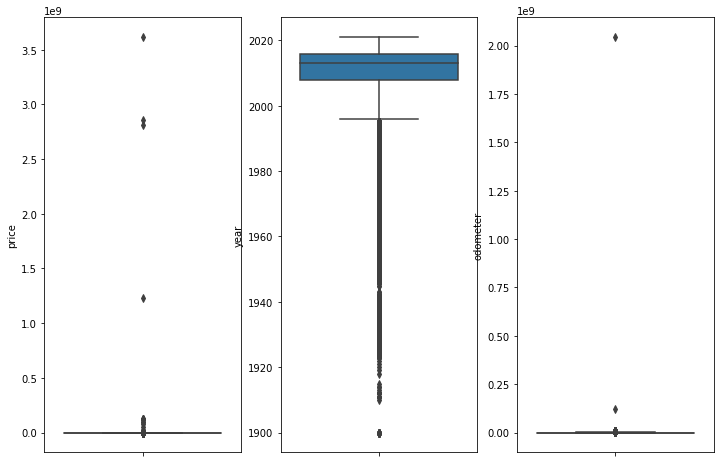

In [173]:
# boxplots
fig, axs = plt.subplots(ncols=3, figsize=(12,8))
sns.boxplot(y=car_df['price'], ax=axs[0])
sns.boxplot(y=car_df['year'], ax=axs[1])
sns.boxplot(y=car_df['odometer'], ax=axs[2])
plt.show()

In [174]:
#how many nas?
car_df.isna().sum()

Unnamed: 0      0     
id              0     
url             0     
region          0     
region_url      0     
price           0     
year            1050  
manufacturer    18220 
model           4846  
condition       192940
cylinders       171140
fuel            3237  
odometer        55303 
title_status    2577  
transmission    2442  
VIN             187549
drive           134188
size            321348
type            112738
paint_color     140843
image_url       28    
description     70    
state           0     
lat             7448  
long            7448  
posting_date    28    
dtype: int64

In [93]:
#impute year and odometer so that histograms will work
#df['year'] = df['year'].fillna(df['year'].median())
#df['odometer'] = df['odometer'].fillna(df['odometer'].median())

C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


ValueError: cannot convert float NaN to integer

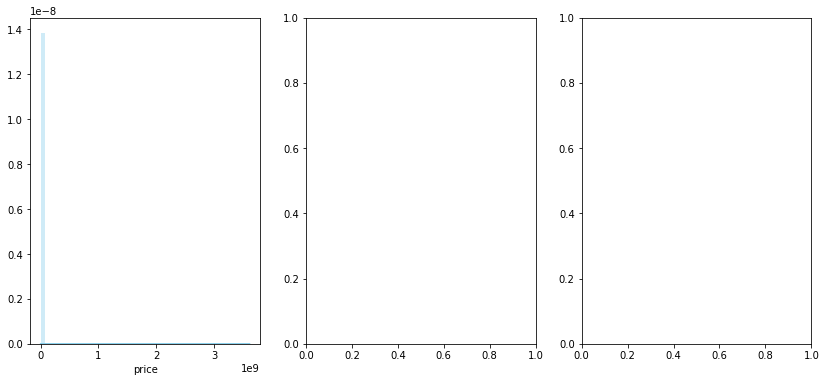

In [175]:
#histograms
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=False)
sns.distplot(car_df['price'] , color="skyblue", ax=axes[0])
sns.distplot(car_df['year'] , color="skyblue", ax=axes[1])
sns.distplot(car_df['odometer'] , color="skyblue", ax=axes[2])


In [176]:
#how many nas?
df.isna().sum()

Unnamed: 0      0     
id              0     
url             0     
region          0     
region_url      0     
price           0     
year            1050  
manufacturer    18220 
model           4846  
condition       192940
cylinders       171140
fuel            3237  
odometer        55303 
title_status    2577  
transmission    2442  
VIN             187549
drive           134188
size            321348
type            112738
paint_color     140843
image_url       28    
description     70    
state           0     
lat             7448  
long            7448  
posting_date    28    
dtype: int64

In [177]:
#convert posting_date to datetime object
car_df['posting_date'] = car_df['posting_date'].astype('datetime64[ns]')

In [178]:
#get the date range of the dataset
print(min(car_df['posting_date']))
print(max(car_df['posting_date']))

2020-10-23 04:58:26
2020-12-03 16:32:54


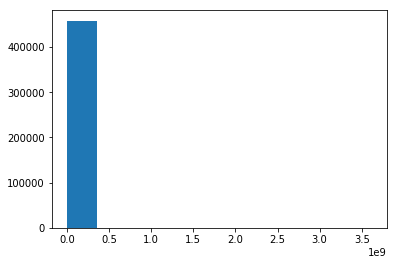

In [179]:
#histogram price
plt.hist(car_df['price'], bins=10)
plt.show()

In [180]:
#check for outlier and dummy data
print("greater than 999998 ")# + 
car_df[car_df['price'] > 999998]

greater than 999998 


Unnamed: 0          id  \
1622    1622        7229441403   
21955   21955       7237530256   
25413   25413       7231485425   
38375   38375       7233307527   
107009  107009      7240359259   
109428  109428      7236905649   
109654  109654      7233969062   
117008  117008      7239979807   
145053  145053      7230202474   
151283  151283      7238742470   
151323  151323      7234647563   
167398  167398      7227573340   
174403  174403      7232219548   
185946  185946      7233662688   
190027  190027      7236130927   
191736  191736      7235342524   
191738  191738      7235338576   
215250  215250      7239823363   
219541  219541      7237551988   
238861  238861      7239202090   
256573  256573      7232376217   
267603  267603      7237716839   
277726  277726      7237729041   
304139  304139      7232956812   
305894  305894      7237186781   
306217  306217      7232214947   
326182  326182      7226122761   
339197  339197      7236920317   
339213  339213      7236876446   
346637  346637      7238892738   
358275  358275      7230619263   
360640  360640      7237394192   
362163  362163      7235334409   
364274  364274      7237398080   
369909  369909      7237527839   
370801  370801      7240732518   
372613  372613      7237529025   
374346  374346      7237530934   
384531  384531      7237526817   
385434  385434      7237527212   
386045  386045      7239118846   
389721  389721      7237533925   
392756  392756      7237534748   
393667  393667      7229165030   
399972  399972      7232485685   
414603  414603      7230103787   
414605  414605      7230098276   
425188  425188      7236646658   

                                                                                                      url  \
1622    https://bham.craigslist.org/cto/d/trussville-1955-chevy-belair-hardtop/7229441403.html              
21955   https://texarkana.craigslist.org/ctd/d/belton-37th-annual-nationally/7237530256.html                
25413   https://chico.craigslist.org/cto/d/proberta-mazdanissan/7231485425.html                             
38375   https://modesto.craigslist.org/ctd/d/modesto-will-buy-single-cab-lifted/7233307527.html             
107009  https://miami.craigslist.org/brw/cto/d/hollywood-used-car-lot-for-lease-or-sale/7240359259.html     
109428  https://spacecoast.craigslist.org/ctd/d/royal-palm-beach-2017-jeep-wrangler/7236905649.html         
109654  https://spacecoast.craigslist.org/cto/d/satellite-beach-classic-car-bike-truck/7233969062.html      
117008  https://atlanta.craigslist.org/nat/cto/d/cumming-classic-cars/7239979807.html                       
145053  https://evansville.craigslist.org/ctd/d/evansville-2006-jeep-wrangler-sport/7230202474.html         
151283  https://terrehaute.craigslist.org/ctd/d/evansville-2006-jeeps-wranglers-thru/7238742470.html        
151323  https://terrehaute.craigslist.org/ctd/d/evansville-2006-jeeps-wranglers-thru/7234647563.html        
167398  https://bgky.craigslist.org/cto/d/cave-city-1997-obs-chevrolet-swb-rc/7227573340.html               
174403  https://neworleans.craigslist.org/cto/d/covington-2015-toyota-pre-runner/7232219548.html            
185946  https://capecod.craigslist.org/cto/d/cotuit-2000-jeep-wrangler-trades-only/7233662688.html          
190027  https://worcester.craigslist.org/cto/d/leominster-dr-studebaker-lark/7236130927.html                
191736  https://annarbor.craigslist.org/ctd/d/great-falls-liquidating-car-collection/7235342524.html        
191738  https://annarbor.craigslist.org/ctd/d/great-falls-liquidating-car-collection/7235338576.html        
215250  https://minneapolis.craigslist.org/ank/ctd/d/little-falls-wholesale-lot-open-to/7239823363.html     
219541  https://natchez.craigslist.org/cto/d/great-falls-selling-lifetime-car/7237551988.html               
238861  https://fayetteville.craigslist.org/cto/d/fayetteville-ford-ranger-chevy-tahoe/7239202090.html      
256573  https://cnj.craigslist.org/cto/d/farmingdale

In [182]:
car_df[car_df['price'] > 150000].count()

Unnamed: 0      235
id              235
url             235
region          235
region_url      235
price           235
year            234
manufacturer    151
model           221
condition       103
cylinders       149
fuel            231
odometer        192
title_status    233
transmission    234
VIN             147
drive           119
size            52 
type            132
paint_color     150
image_url       235
description     235
state           235
lat             232
long            232
posting_date    235
dtype: int64

In [183]:
#only keep cars < 150000
car_df=car_df[car_df['price'] < 3000000] 

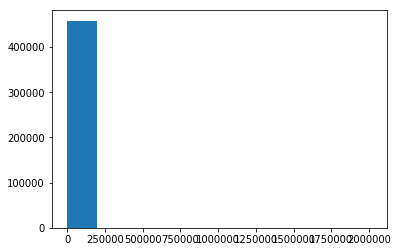

In [184]:
#histogram price
plt.hist(car_df['price'], bins=10)
plt.show()

In [185]:
#check how many are zero
car_df.loc[car_df['price'] == 0, 'price'].count()

33753

In [186]:
#try to take the log price (this is going to be a problem becaue of the zeros)
car_df.loc[(car_df.price == 0),'price']= 0.001
car_df['log_price']=car_df["price"].apply(np.log)


C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
df['log_price'].describe()

count    457974.000000
mean          8.044757
std           4.372690
min          -6.907755
25%           8.496990
50%           9.305196
75%           9.971321
max          11.918357
Name: log_price, dtype: float64

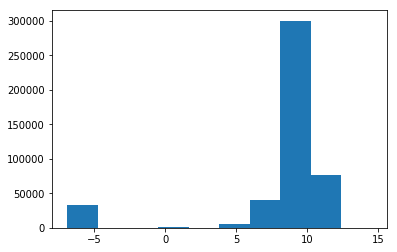

In [187]:
#histogram log price
plt.hist(car_df['log_price'])
plt.show()

In [188]:
#info
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458190 entries, 0 to 458212
Data columns (total 27 columns):
Unnamed: 0      458190 non-null int64
id              458190 non-null int64
url             458190 non-null object
region          458190 non-null object
region_url      458190 non-null object
price           458190 non-null float64
year            457140 non-null float64
manufacturer    439973 non-null object
model           453348 non-null object
condition       265262 non-null object
cylinders       287059 non-null object
fuel            454953 non-null object
odometer        402901 non-null float64
title_status    455613 non-null object
transmission    455748 non-null object
VIN             270662 non-null object
drive           324011 non-null object
size            136855 non-null object
type            345465 non-null object
paint_color     317359 non-null object
image_url       458162 non-null object
description     458120 non-null object
state           458190 non-nul

C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


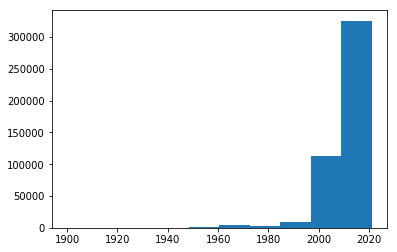

In [189]:
#histogram year
plt.hist(car_df['year'], bins=10)
plt.show()

In [190]:
#breakdown of car condition
car_df.groupby('condition')['id'].nunique()

condition
excellent    115201
fair         7740  
good         115681
like new     24551 
new          1428  
salvage      661   
Name: id, dtype: int64

Text(0, 0.5, 'Frequency')

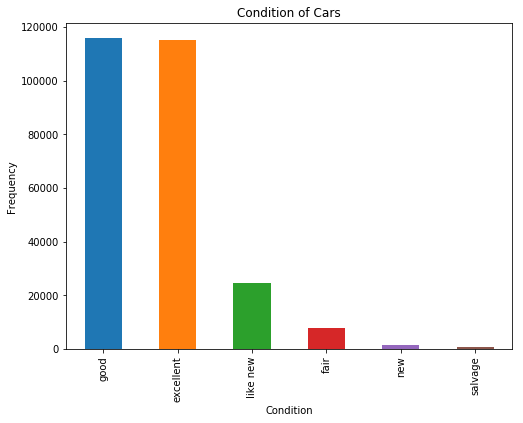

In [191]:
#plot the conditions
ax = car_df['condition'].value_counts().plot(kind='bar',
                                    figsize=(8,6),
                                    title="Condition of Cars")
ax.set_xlabel("Condition")
ax.set_ylabel("Frequency")

In [192]:
#condition has almost 200,000 na's
car_df['condition'].isna().sum()

192928

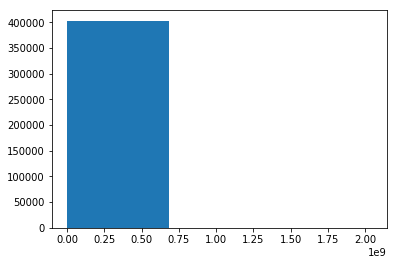

In [193]:
#histogram year
plt.hist(car_df['odometer'], bins=3)
plt.show()

In [194]:
#odometer
car_df['odometer'].describe()

count    4.029010e+05
mean     1.016679e+05
std      3.228658e+06
min      0.000000e+00
25%      4.087700e+04
50%      8.764100e+04
75%      1.340000e+05
max      2.043756e+09
Name: odometer, dtype: float64

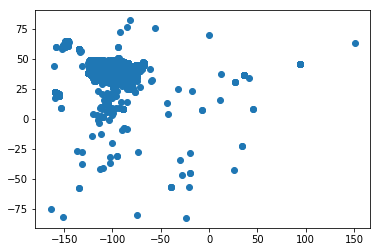

In [195]:
#plot latitude and longitude
plt.scatter(x=car_df['long'], y=car_df['lat'])
plt.show()

In [ ]:
# map of cars for sale:  https://towardsdatascience.com/pythons-geocoding-convert-a-list-of-addresses-into-a-map-f522ef513fd6
# fig = px.scatter_geo(df, 
#                      lon="long", 
#                      lat="lat", 
#                     projection="natural earth")

In [ ]:
# fig.update_geos(fitbounds="locations", showcountries = True) - Commented out because it takes all resources
# fig.update_layout(title = "Cars for Sale on Craig's list")
# fig.show()

In [ ]:
#convert posting date

In [196]:
#group by state
df_st = car_df.groupby(['state']).count().reset_index()

In [197]:
df_st.head()

state  Unnamed: 0     id    url  region  region_url  price   year  \
0  ak    3965        3965   3965   3965    3965        3965   3962    
1  al    5714        5714   5714   5714    5714        5714   5653    
2  ar    4789        4789   4789   4789    4789        4789   4777    
3  az    8886        8886   8886   8886    8886        8886   8835    
4  ca    51854       51854  51854  51854   51854       51854  51788   

   manufacturer  model  condition  cylinders   fuel  odometer  title_status  \
0  3904          3933   1406       2969       3957   3655      3965           
1  5410          5684   3306       3841       5636   4792      5560           
2  4611          4711   2940       2543       4785   3453      4773           
3  8427          8774   5717       6106       8824   8219      8770           
4  50026         51218  33752      31167      51694  46032     51551          

   transmission    VIN  drive   size   type  paint_color  image_url  \
0  3928          3092   3299   798    3553   3043         3965        
1  5710          3173   3858   1968   3846   4324         5714        
2  4780          1899   2762   1285   2819   2918         4788        
3  8857          4738   6278   2718   6871   6391         8885        
4  51664         33025  35685  14612  41037  36147        51853       

   description    lat   long  posting_date  log_price  
0  3965         3965   3965   3965          3965       
1  5714         5671   5671   5714          5714       
2  4788         4756   4756   4788          4789       
3  8885         8870   8870   8885          8886       
4  51853        51724  51724  51853         51854

In [198]:
#drop extra ID fields, URL fields, region fields, and description
car_df = car_df.drop(columns=['Unnamed: 0','url','region','region_url','description'])

In [200]:
#how many nas?
car_df.isna().sum()

id              0     
price           0     
year            1050  
manufacturer    18217 
model           4842  
condition       192928
cylinders       171131
fuel            3237  
odometer        55289 
title_status    2577  
transmission    2442  
VIN             187528
drive           134179
size            321335
type            112725
paint_color     140831
image_url       28    
state           0     
lat             7448  
long            7448  
posting_date    28    
log_price       0     
dtype: int64

In [ ]:
#drop NAs
#df = df.dropna()

In [201]:
#convert year to an int and keep cars that are 1930 and greater
car_df=car_df[car_df['year']>1929]
car_df['year']=car_df['year'].astype(int)

In [202]:
car_df.shape

(456938, 22)

In [204]:
car_df['state'].unique()

array(['al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga',
       'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma',
       'mi', 'mn', 'ms', 'mo', 'mt', 'nc', 'ne', 'nv', 'nj', 'nm', 'ny',
       'nh', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx',
       'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy'], dtype=object)

In [205]:
car_df['manufacturer'].unique()

array(['chevrolet', 'hyundai', 'bmw', 'ford', 'toyota', 'jeep', 'ram',
       nan, 'honda', 'dodge', 'lexus', 'mercedes-benz', 'cadillac', 'gmc',
       'subaru', 'infiniti', 'mazda', 'mini', 'nissan', 'volkswagen',
       'kia', 'lincoln', 'mitsubishi', 'buick', 'audi', 'rover',
       'chrysler', 'fiat', 'acura', 'volvo', 'pontiac', 'tesla', 'saturn',
       'mercury', 'datsun', 'porsche', 'jaguar', 'ferrari', 'alfa-romeo',
       'harley-davidson', 'land rover', 'aston-martin', 'morgan',
       'hennessey'], dtype=object)

In [206]:
np.set_printoptions(threshold=np.inf)
print(len(car_df['model'].unique()))

31292


In [207]:
car_df['condition'].unique()

array(['good', 'excellent', nan, 'like new', 'fair', 'salvage', 'new'],
      dtype=object)

In [208]:
car_df['cylinders'].unique()
len(df[df['cylinders'] == "other"])

1112

In [209]:
car_df['fuel'].unique()

array(['gas', 'diesel', 'other', 'hybrid', nan, 'electric'], dtype=object)

In [210]:
car_df['title_status'].unique()

array(['clean', 'lien', 'missing', 'salvage', 'rebuilt', nan,
       'parts only'], dtype=object)

In [211]:
car_df['transmission'].unique()

array(['other', 'automatic', 'manual', nan], dtype=object)

In [212]:
car_df['drive'].unique()

array(['rwd', 'fwd', nan, '4wd'], dtype=object)

In [213]:
car_df['size'].unique()

array([nan, 'full-size', 'mid-size', 'compact', 'sub-compact'],
      dtype=object)

In [214]:
car_df['type'].unique()

array(['other', 'sedan', 'SUV', 'pickup', 'coupe', 'van', nan, 'truck',
       'mini-van', 'wagon', 'convertible', 'hatchback', 'bus', 'offroad'],
      dtype=object)

In [215]:
car_df[car_df['manufacturer']=='harley-davidson'].groupby(['type']).count().reset_index()

type  id  price  year  manufacturer  model  condition  cylinders  fuel  \
0  offroad  1   1      1     1             0      1          1          1      
1  other    33  33     33    33            33     2          1          33     
2  pickup   13  13     13    13            13     11         13         13     
3  truck    13  13     13    13            12     11         10         13     

   odometer  title_status  transmission  VIN  drive  size  paint_color  \
0  0         1             1             0    1      1     1             
1  33        33            9             33   0      0     25            
2  13        13            13            8    13     11    13            
3  12        13            13            3    11     10    11            

   image_url  state  lat  long  posting_date  log_price  
0  1          1      1    1     1             1          
1  33         33     32   32    33            33         
2  13         13     13   13    13            13         
3  13         13     13   13    13            13

In [216]:
len(car_df[car_df['type']=='other'])
#group by state
#df_type = df.groupby(['type']).count().reset_index()
df_type

type  Unnamed: 0     id    url  region  region_url  price   year  \
0   SUV          79882       79882  79882  79882   79882       79882  79619   
1   bus          717         717    717    717     717         717    717     
2   convertible  6864        6864   6864   6864    6864        6864   6855    
3   coupe        19106       19106  19106  19106   19106       19106  19091   
4   hatchback    16388       16388  16388  16388   16388       16388  16381   
5   mini-van     6263        6263   6263   6263    6263        6263   6263    
6   offroad      647         647    647    647     647         647    647     
7   other        24160       24160  24160  24160   24160       24160  24137   
8   pickup       43343       43343  43343  43343   43343       43343  42989   
9   sedan        92364       92364  92364  92364   92364       92364  92162   
10  truck        35694       35694  35694  35694   35694       35694  35694   
11  van          9574        9574   9574   9574    9574        9574   9505    
12  wagon        10473       10473  10473  10473   10473       10473  10470   

    manufacturer  model  condition  cylinders   fuel  odometer  title_status  \
0   78505         79501  48358      63474      79285  75546     79407          
1   456           689    560        536        712    639       717            
2   6283          6823   5202       5323       6854   6308      6849           
3   17914         18987  14854      14642      19072  17859     19027          
4   15835         16361  13153      8680       16343  15811     16332          
5   6151          6231   5251       5039       6233   5828      6258           
6   590           625    625        599        647    522       647            
7   23056         23959  13086      10829      23880  23513     24122          
8   42695         42622  27170      29942      42889  41627     43019          
9   90498         92085  62814      68853      91806  87323     91884          
10  33412         35318  23480      31095      35644  33223     35674          
11  9316          9528   6447       8258       9475   9165      9510           
12  10229         10454  5478       6175       10459  10161     10442          

    transmission    VIN  drive   size  paint_color  image_url  description  \
0   79684         52502  68915  33485  64786        79882      79867         
1   716           179    541    227    497          717        717           
2   6833          3820   5759   3027   5937         6864       6863          
3   19015         12318  16392  7555   16534        19106      19106         
4   16277         11336  13439  6041   14020        16388      16387         
5   6260          3071   5452   2995   5207         6263       6261          
6   647           130    618    431    606          647        647           
7   23590         22027  12287  1410   20051        24160      24160         
8   43137         33914  35312  9921   37595        43343      43343         
9   92053         59779  76838  40875  76586        92364      92354         
10  35644         22471  33506  19032  28231        35694      35682         
11  9560          6494   8077   4635   8264         9574       9574          
12  10374         7822   8764   3000   8648         10473      10473         

    state    lat   long  posting_date  
0   79882  78187  78187  79882         
1   717    629    629    717           
2   6864   6816   6816   6864          
3   19106  18882  18882  19106         
4   16388  16281  16281  16388         
5   6263   6163   6163   6263          
6   647    644    644    647           
7   24160  23196  23196  24160         
8   43343  42768  42768  43343         
9   92364  90903  90903  92364         
10  35694  34534  34534  35694         
11  9574   9355   9355   9574          
12  10473  10330  10330  10473

In [217]:
car_df['paint_color'].unique()

array([nan, 'blue', 'red', 'silver', 'black', 'white', 'grey', 'orange',
       'green', 'yellow', 'custom', 'brown', 'purple'], dtype=object)

In [ ]:
car_df['posting_date'].unique()

C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Kristi\Anaconda3\envs\my_environment\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


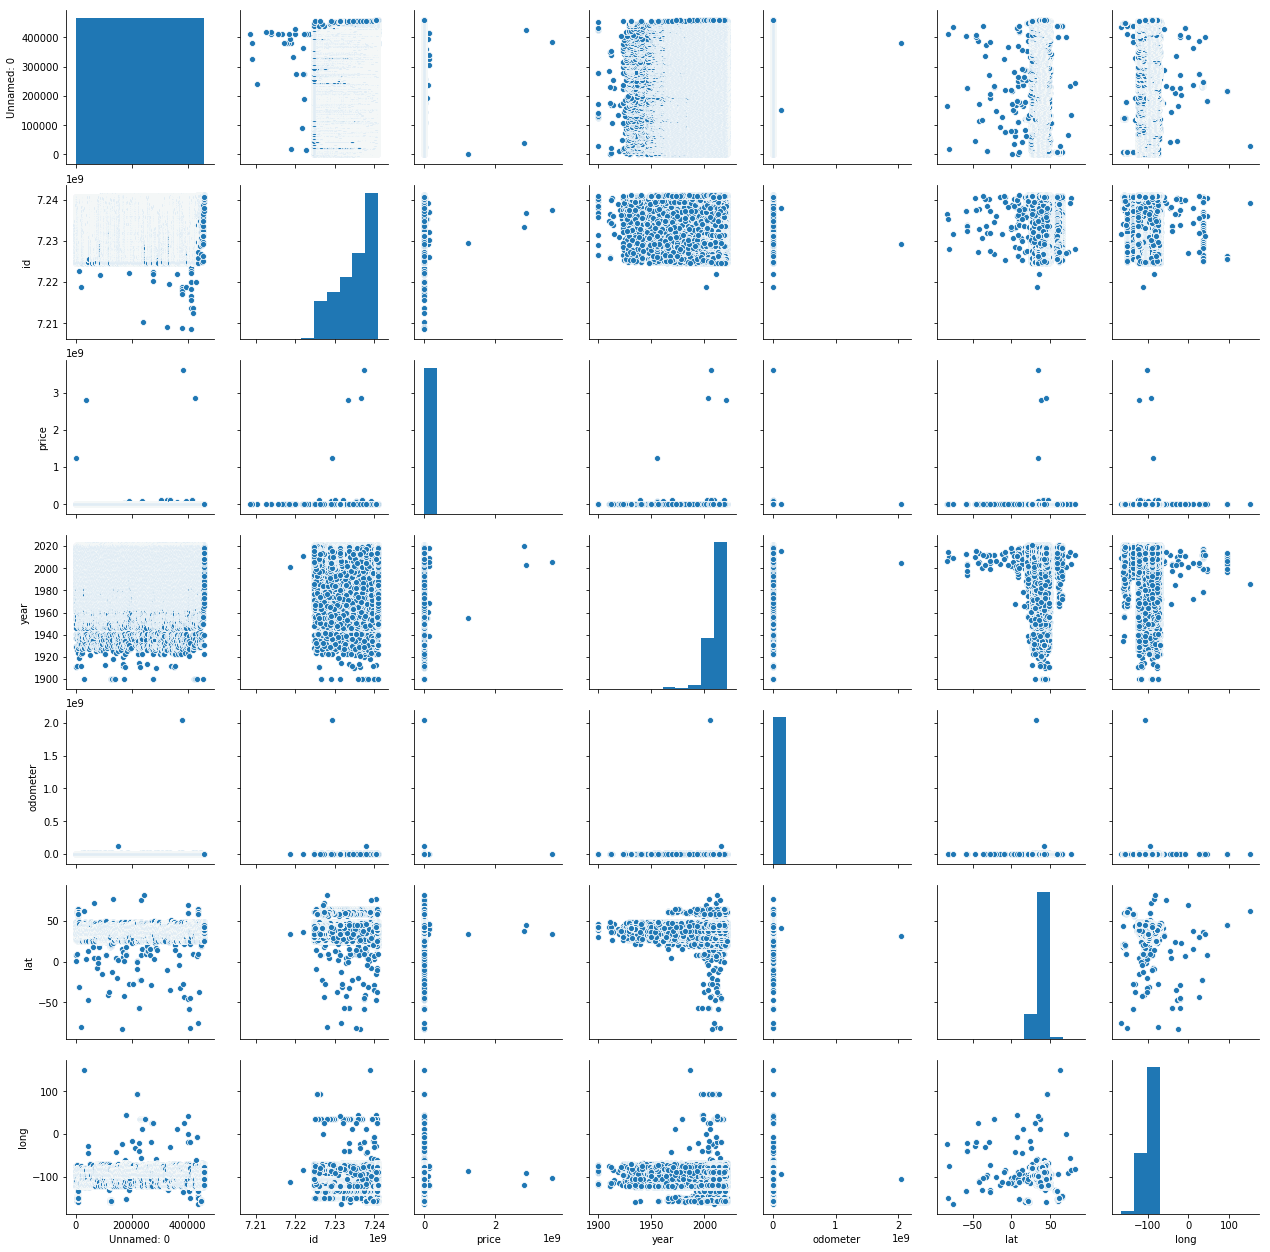

In [16]:
# Basic correlogram
sns.pairplot(car_df)
#sns.plt.show()